# 获取数据

In [4]:
import flynnBot.flynnBot as fbot

In [5]:
sym = '000333'

start = '2020-01-01'
end = '2021-12-2'

bot = fbot.flynnBot(sym, 100000, 0, start, end)
df = bot.fetch()
df.tail(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,date_str,ema_48,ema_14
493,2021-11-26,68.81,69.45,68.58,69.00,14048380,68.81,69.45,68.58,69.00,14048380,0.0,1.0,2021-11-26,70.273063,69.502537
494,2021-11-29,68.17,68.58,67.72,67.99,20002100,68.17,68.58,67.72,67.99,20002100,0.0,1.0,2021-11-29,70.090188,69.058358
495,2021-11-30,67.78,69.15,67.67,67.86,19543670,67.78,69.15,67.67,67.86,19543670,0.0,1.0,2021-11-30,69.889302,68.632239
496,2021-12-01,68.16,68.20,67.20,67.67,18010100,68.16,68.20,67.20,67.67,18010100,0.0,1.0,2021-12-01,69.738928,68.474826
497,2021-12-02,67.74,67.74,67.74,67.74,17292840,67.74,67.74,67.74,67.74,17292840,0.0,1.0,2021-12-02,69.565108,68.229884


In [31]:

df = df.drop(['close', 'high', 'low', 'open', 'volume', 'divCash', 'splitFactor', 'date_str', 'ema_48', 'ema_14'], axis=1)
df.head(3)

,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume
0,2020-01-01,55.571984,55.571984,55.571984,55.571984,0
1,2020-01-02,57.003023,57.136586,55.724629,55.963135,34622560
2,2020-01-03,55.581525,57.203368,55.505203,57.146126,27004260


### 统计一下每一天的平均价格， 和对应的成交量

In [32]:
df['mid'] = (df['adjClose'] + df['adjHigh'] + df['adjLow']) / 3
df['midRound'] = df['mid'].round(0).astype(int)
df.head(3)

,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,mid,midRound
0,2020-01-01,55.571984,55.571984,55.571984,55.571984,0,55.571984,56
1,2020-01-02,57.003023,57.136586,55.724629,55.963135,34622560,56.621412,57
2,2020-01-03,55.581525,57.203368,55.505203,57.146126,27004260,56.096698,56


# 计算每个价格的成交量

In [33]:
df1 = df.iloc[-60:,:]
dfVol = df1.groupby(['midRound'], as_index=False)['adjVolume'].sum()

dfVol

,midRound,adjVolume
0,66,53434010
1,67,86946110
2,68,196594010
3,69,278874550
4,70,241761260
5,71,193394690
6,72,253171370
7,73,238380010


<BarContainer object of 8 artists>

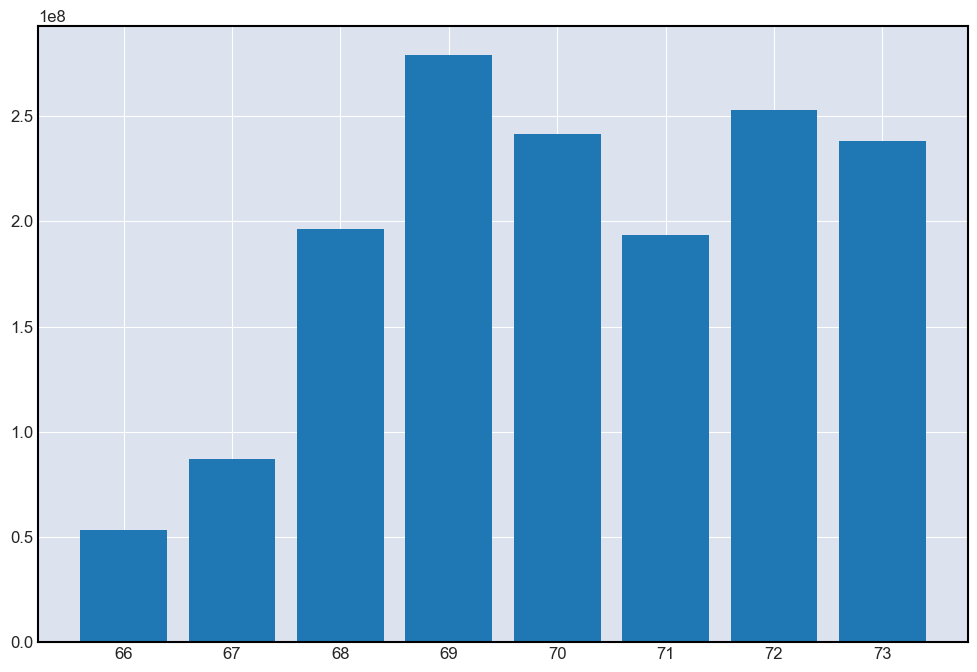

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plt.bar(x=dfVol['midRound'], height=dfVol['adjVolume'])

### vwap

In [35]:
vwapdays = 20

# 一天的成交额
df['turnVol'] = df['adjVolume'] * df['mid']
# 最近总的成交额
df['recentTurnVol'] = 0
# 最近总的成交量
df['recentVol'] = 0
df['vwap'] = 0

indexTurnVol = df.columns.get_loc('turnVol')
indexV = df.columns.get_loc('adjVolume')
for i in range(vwapdays, len(df)):
    # n 天的成交额和成交量
    recentTV = df.iloc[i-vwapdays:i+1, indexTurnVol].sum()
    recentV = df.iloc[i-vwapdays:i+1, indexV].sum()
    # 今天的vwap
    vwap = recentTV / recentV
    idx = df.index[i]
    # 保存数据
    df.loc[idx, 'vwap'] = vwap
    df.loc[idx, 'recentTurnVol'] = recentTV
    df.loc[idx, 'recentVol'] = recentV

## 计算均价

In [36]:
df['sma'] = df['adjClose'].rolling(vwapdays).mean()
df['sma60'] = df['adjClose'].rolling(60).mean()

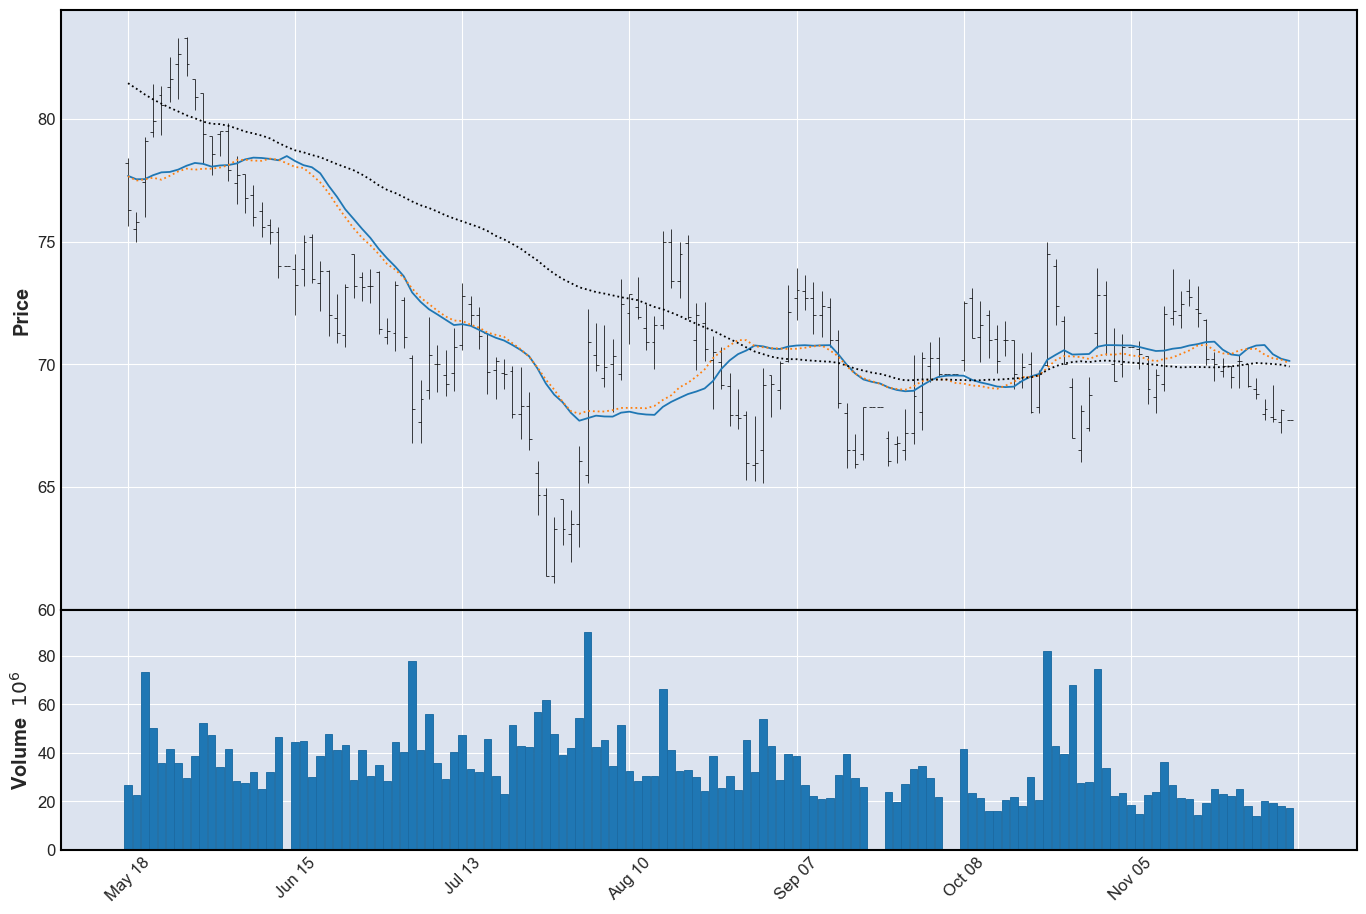

In [37]:
import mplfinance as mpf
import pandas as pd

mpl_columns = {
    'adjOpen':'Open',
    'adjClose':'Close',
    'adjLow':'Low',
    'adjHigh':'High',
    'adjVolume':'Volume'
}

df1 = df.iloc[-140:,]
dfView = df1.rename(columns=mpl_columns)
dfView['Datetime'] = pd.to_datetime(df['date'])
dfView = dfView.set_index(['Datetime'])

vwap = mpf.make_addplot(dfView['vwap'], secondary_y=False)
sma = mpf.make_addplot(dfView['sma'], linestyle='dotted', secondary_y=False)

sma60 = mpf.make_addplot(dfView['sma60'], linestyle='dotted', color='black', secondary_y=False)


mpf.plot(dfView, figsize=(18, 12), addplot=[vwap, sma, sma60], volume=True)